In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import json
import sys

In [33]:
# Load data
df_auto = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t').astype('object')
df_single = pd.read_csv('./project_pipeline/data/single_domain_pae.tsv', sep='\t').astype('object')
df_multi = pd.read_csv('./project_pipeline/data/multi_domain_pae.tsv', sep='\t').astype('object')

plt.style.use('ggplot')

Reformat the dataframes

In [34]:
df_pae = df_auto[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']]

# Remove all rows with multiple regions. Comment this out if you want to see the difference.
for i in range(len(df_single)):
    region = df_single.loc[i, 'region']
    count = region.count('-')
    if count > 1:
        df_single = df_single.drop(i)


# Reformat the singles dataframe
df_single = df_single[['uniprot', 'mean_pae']].dropna()
df_single = df_single.astype({'mean_pae': 'float'})
df_single = df_single.rename(columns={'mean_pae': 'Single Domain'})
df_single_melt = df_single.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')

# Reformat all pae dataframe
df_pae = df_pae.rename(columns={'mean_pae_1_1': 'IM-IM', 'mean_pae_1_2': 'IM-FD', 'mean_pae_2_2': 'FD-FD'})
df_pae_melt = df_pae.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')

# Reformat the multi dataframe
df_multi = df_multi[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_multi = df_multi.rename(columns={'mean_pae_1_1': 'D1-D1', 'mean_pae_1_2': 'D1-D2', 'mean_pae_2_2': 'D2-D2'})
df_multi_melt = df_multi.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')

# Add type column
df_pae_melt['type'] = 'Autoinhibitory'
df_single_melt['type'] = 'Single Domain'
df_multi_melt['type'] = 'Two-Domain'

# Merge all dataframes
df_all = pd.concat([df_single_melt, df_pae_melt, df_multi_melt], ignore_index=True)
df_all['mean_pae'] = df_all['mean_pae'].astype('float')
df_all.head(30)

,uniprot,region,mean_pae,type
0,P03372,Single Domain,4.421,Single Domain
1,P00533,Single Domain,5.973,Single Domain
2,P03069,Single Domain,4.649,Single Domain
3,Q00987,Single Domain,2.809,Single Domain
4,P00974,Single Domain,1.399,Single Domain
5,P41182,Single Domain,16.121,Single Domain
6,P19793,Single Domain,5.620,Single Domain
7,Q03181,Single Domain,3.773,Single Domain
8,P04150,Single Domain,4.285,Single Domain
9,P11473,Single Domain,10.716,Single Domain


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM-FD_Autoinhibitory vs. IM-IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided, P_val:1.897e-71 U_stat=5.120e+05
IM-IM_Autoinhibitory vs. FD-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided, P_val:4.668e-08 U_stat=3.922e+05
D1-D2_Two-Domain vs. D1-D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.595e-07 U_stat=2.312e+03
D1-D1_Two-Domain vs. D2-D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:6.310e-03 U_stat=1.903e+03
IM-FD_Autoinhibitory vs. FD-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided, P_val:3.359e-120 U_stat=5.645e+05
D1-D2_Two-Domain vs. D2-D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.515e-13 U_stat=2.650e+03


(<Axes: title={'center': 'Average PAE Across Domains'}, xlabel='Domains Compared', ylabel='Average PAE'>,
  <statannotations.Annotation.Annotation at 0x7f9fc4d8fed0>])

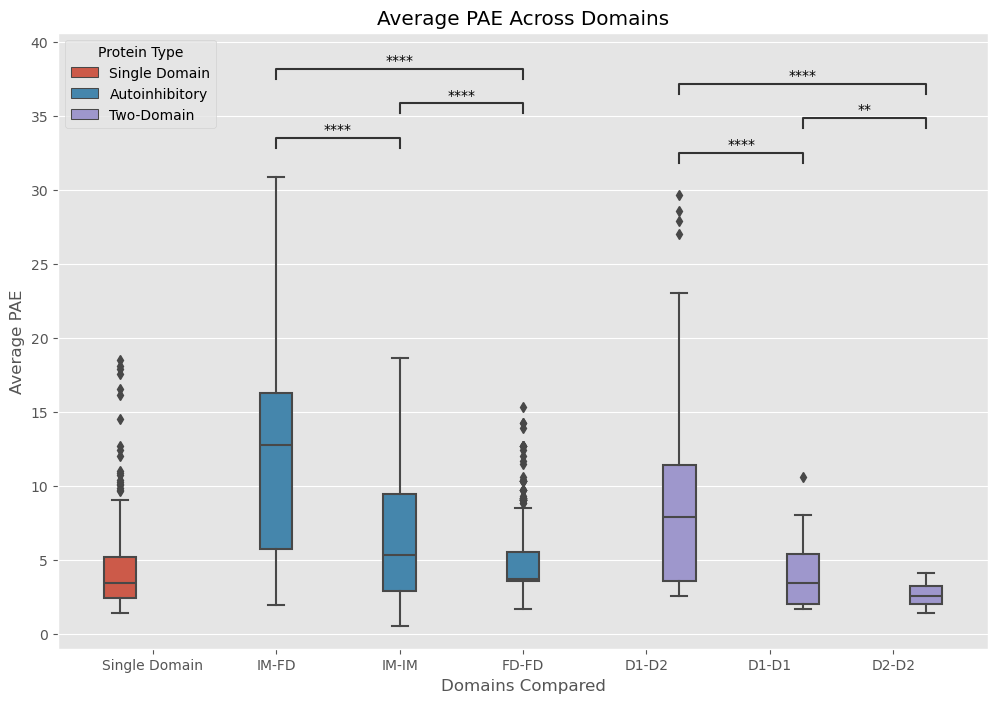

In [35]:
region_order = ['Single Domain', 'IM-FD', 'IM-IM', 'FD-FD', 'D1-D2', 'D1-D1', 'D2-D2']

f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_all, x='region', y='mean_pae', hue='type', order=region_order, ax=ax)
ax.set_xlabel('Domains Compared')
ax.set_ylabel('Average PAE')
ax.set_title('Average PAE Across Domains')
ax.legend(title='Protein Type')

plt.savefig('./project_pipeline/data/figures/auto_sd_md_proteins_pae.png')

# Annotate statistical significance

pairs = [[('IM-FD', 'Autoinhibitory'), ('IM-IM', 'Autoinhibitory')],
         [('IM-FD', 'Autoinhibitory'), ('FD-FD', 'Autoinhibitory')],
         [('IM-IM', 'Autoinhibitory'), ('FD-FD', 'Autoinhibitory')],
         [('D1-D2', 'Two-Domain'), ('D1-D1', 'Two-Domain')],
         [('D1-D2', 'Two-Domain'), ('D2-D2', 'Two-Domain')],
         [('D1-D1', 'Two-Domain'), ('D2-D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

We're going to slightly change the order

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D2-D2_Two-Domain vs. FD-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.559e-18 U_stat=6.068e+03
D1-D1_Two-Domain vs. IM-IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.549e-04 U_stat=1.467e+04
D1-D2_Two-Domain vs. IM-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.994e-03 U_stat=1.658e+04
Single Domain_Single Domain vs. D2-D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.899e-05 U_stat=9.776e+03
Single Domain_Single Domain vs. FD-FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.577e-06 U_stat=8.418e+04
Single Domain_Single Domain vs. D1-D1_Two-Domain: Mann-Whitney-Wilcoxon test two-side

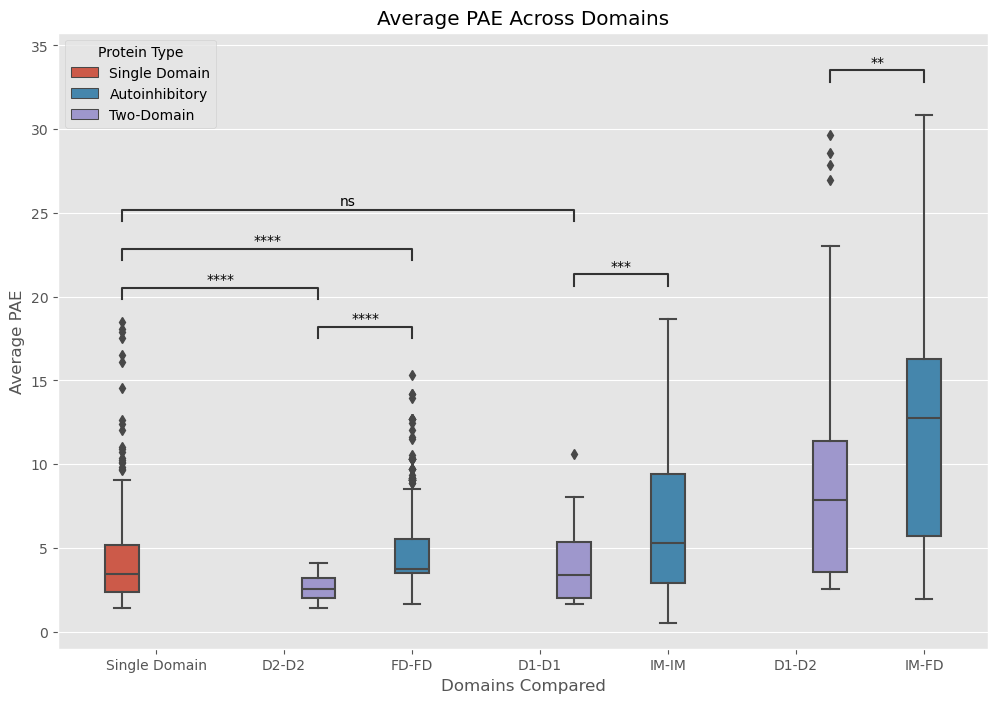

In [36]:
region_order = ['Single Domain', 'D2-D2', 'FD-FD', 'D1-D1', 'IM-IM', 'D1-D2', 'IM-FD']

f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_all, x='region', y='mean_pae', hue='type', order=region_order, ax=ax)
ax.set_xlabel('Domains Compared')
ax.set_ylabel('Average PAE')
ax.set_title('Average PAE Across Domains')
ax.legend(title='Protein Type')

plt.savefig('./project_pipeline/data/figures/auto_sd_md_proteins_pae.png')

# Annotate statistical significance

pairs = [[('Single Domain', 'Single Domain'), ('FD-FD', 'Autoinhibitory')],
         [('Single Domain', 'Single Domain'), ('D2-D2', 'Two-Domain')],
         [('Single Domain', 'Single Domain'), ('D1-D1', 'Two-Domain')],
         [('FD-FD', 'Autoinhibitory'), ('D2-D2', 'Two-Domain')],
         [('IM-IM', 'Autoinhibitory'), ('D1-D1', 'Two-Domain')],
         [('IM-FD', 'Autoinhibitory'), ('D1-D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()